### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


## Часть 1. Логистическая регрессия своими руками (4 балла)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (1.5 балла). Градиентного спуска**

**Задание 2 (1.5 балла). Стохастического градиентного спуска**

Во всех пунктах необходимо соблюдать следующие условия:
- Градиентный спуск необходимо записать в векторном виде
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):
    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

In [2]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import shuffle

"""
Основные особенности реализации эстиматора: 
- для проверок входных данных и состояния эстиматора используются встроенные функции 
  check_X_y, check_array, check_is_fitted библиотеки scikit-learn
- эстиматор реализует как обычный градиентный спуск, так и стохастический, включая  mini batch SGD. 
  Для задания размера батча используется параметр batch_size. Если установить его равным 1, то 
  мы получим обычный SGD. 
  Кроме того, эстиматору можно задать параметр use_epochs, который определяет алгоритм получения
  батчей. use_epochs = False приведет к тому, что батчи на каждой итерации будут получаться случайным
  образом из всего набора данных. При use_epochs = True на каждой итерации батч берется из 
  сформированного набора батчей эпохи, покрывающего весь датасет. Когда в рамках эпохи заканчиваются 
  батчи, генерируется новая эпоха с новым набором батчей       
"""

class LogReg(BaseEstimator):
    """
    Некоторые проектные 
    """
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2, batch_size = 16, use_epochs = True):
        """
        gd_type: 'full' or 'stochastic' 
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        batch_size: size of a batch in mini batch SGD if gd_type is set to 'stochastic'; ignored otherwise 
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.batch_size = batch_size
        self.loss_history = None 
        self.use_epochs = use_epochs 
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        
        # выполняем проверку входных данных с помощью спец.функций
        # из scikit-learn (в соответствии с рекомендациями в статье 
        # Developing scikit-learn estimators) 
        X, y = check_X_y(X, y)
        
        
        self.coef_ = np.zeros(X.shape[1]) if self.w0 is None else self.w0
        self.loss_history = [self.calc_loss(X, y)]
        self.__epoch_data = None
        
        for i in range(self.max_iter):

            X_b, y_b = self.__get_next_batch(X, y)

            delta_w = self.eta * self.calc_gradient(X_b,y_b)
            self.coef_ = self.coef_ - delta_w 
            if np.linalg.norm(delta_w) < self.tolerance: 
                break
            self.loss_history.append(self.calc_loss(X,y))
        
        self.is_fitted_ = True
        return self
    
    def __get_next_batch(self, X, y):
        if self.gd_type == 'stochastic':
            if self.use_epochs: 
                return self.__get_batch_from_epoch(X, y)
            else: 
                return self.__get_random_batch(X,y)
        else:
            return X,y
    
    def __get_random_batch(self, X, y):
        batch_obj_indexes = np.random.choice(X.shape[0], self.batch_size, replace=False)
        return X[batch_obj_indexes], y[batch_obj_indexes]
    
    def __get_batch_from_epoch(self, X, y):
        if (self.__epoch_data is None) or (self.__epoch_data['next_batch_index'] > self.__epoch_data['max_batch_index']):
            self.__create_epoch_data(X,y)
        
        X, y, i = self.__epoch_data['X'], self.__epoch_data['y'], self.__epoch_data['next_batch_index']
        self.__epoch_data['next_batch_index'] = i + 1
        start_index = i * self.batch_size
        return X[start_index:(start_index + self.batch_size)], y[start_index:(start_index + self.batch_size)]
        
    def __create_epoch_data(self, X, y):
        X_shuffled, y_shuffled = shuffle(X,y, random_state=42)
        self.__epoch_data =  {'X' : X_shuffled, 'y': y_shuffled, 'next_batch_index':0, 'max_batch_index': (X_shuffled.shape[0] - 1) // self.batch_size}
            
    def predict_proba(self, X):
        """
        X: np.array of shape (ell, d)
        ---
        output: np.array of shape (ell, 2)
        """
        # выполняем проверку входных данных и состояния эстиматора 
        # с помощью спец.функций из scikit-learn в соответствии с 
        # рекомендациями в статье Developing scikit-learn estimators 
        X = check_array(X)
        check_is_fitted(self, 'is_fitted_')
        
        p = self.__calc_probability(X)
        # чтобы результат метода возвращал результат в том же виде, что и 
        # встроенные в scikit-learn модели лог.регрессии, вернем 2 стобца с 
        # оченками вероятности
        return np.vstack((1 - p, p)).T
    
    def __calc_probability(self, X):
         return 1/(1 + np.exp(-(X@ self.coef_)))
    
    def predict(self, X):
        """
        X: np.array of shape (ell, d)
        ---
        output: np.array of shape (ell,)
        """
        return np.argmax(self.predict_proba(X), axis=1)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        return ((self.__calc_probability(X) - y) @ X) / X.shape[0]

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        eps = 1e-9  # чтобы избежать ухода значений log(x) в очень большие 
                    # значения будем добавлять к x EPSILON 
        return -np.mean(y * np.log(self.__calc_probability(X) + eps) +
                        (1-y) * np.log(1 - self.__calc_probability(X) + eps))
        

Синтетические данные

In [3]:
%matplotlib inline

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [4]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

In [15]:
model = LogReg(batch_size=32, max_iter=500, eta=0.01)
model = model.fit(X_train,y_train)

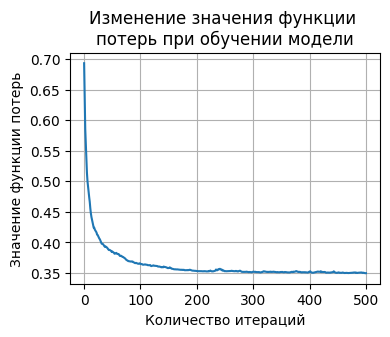

In [16]:
plt.figure(figsize=(4,3))
plt.plot(model.loss_history)
plt.ylabel('Значение функции потерь')
plt.xlabel('Количество итераций')
plt.title('Изменение значения функции \nпотерь при обучении модели')
plt.grid()
plt.show()  

_Как видим по графику функции потерь, даже при числе итераций в 500 и размере батча в 32 эстиматор устойчиво находит минимум_

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

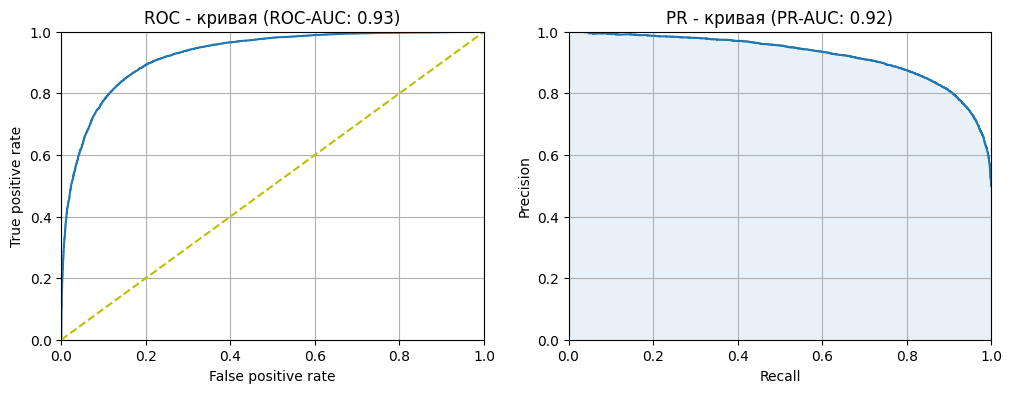

In [17]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

y_test_predicted_proba = model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_test_predicted_proba)
roc_auc = roc_auc_score(y_test, y_test_predicted_proba)

precision, recall, _ = precision_recall_curve(y_test, y_test_predicted_proba)
pr_auc = auc(recall, precision)

plot_dataset = (
    (fpr, tpr, 'False positive rate', 'True positive rate',  f'ROC - кривая (ROC-AUC: {roc_auc:.2f})'),
    (recall, precision, 'Recall', 'Precision',  f'PR - кривая (PR-AUC: {pr_auc:.2f})'),
)

figure, axes = plt.subplots(1,2, figsize=(12,4))
for i in range(2):
    plot_data = plot_dataset[i]    
    axes[i].plot(plot_data[0], plot_data[1])
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])
    axes[i].set_xlabel(plot_data[2])
    axes[i].set_ylabel(plot_data[3])
    axes[i].set_title(plot_data[4])
    axes[i].grid()

axes[0].plot([0, 1], [0, 1], 'y--')
axes[1].fill_between(recall, precision, alpha=0.1)

plt.show()

_Вычисленные значения площадей под кривыми ROC и PR (ROC-AUC и PR-AUC) довольно высокие, что говорит о том, что обученная на синтеческих данных модель логистической регрессии хорошо справляется с задачей классификации._

## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [18]:
import pandas as pd
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [19]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [60]:
%%time
model = LogReg(gd_type='stochastic', use_epochs=True, batch_size=128, max_iter=500, eta=0.1)
model.fit(X_train, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

0.5155059026232849
CPU times: total: 1 s
Wall time: 2.72 s


**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

_Так как полное описание датасета у нас отсутствует, попробуем  кратко проанализировать типы и содержимое столбцов_

In [61]:
column_info = []
for col in X_train.columns:
    column_info.append({
        "Col": col,
        "Type": X_train[col].dtype,
        "Unique_count" : X_train[col].unique().shape[0], 
        "Unique_values": X_train[col].unique() if X_train[col].unique().shape[0]< 10 else ", ".join(map(str, X_train[col].unique()[:10])) + ', ...'
    })
c_info = pd.DataFrame(column_info)

_Сначала посмотрим на столбцы с двумя уникальными значениями и убедимся, что они имеют значения 0 и 1 и их не нужно кодировать_

In [62]:
c_info[c_info['Unique_count'] == 2]

,Col,Type,Unique_count,Unique_values
5,ps_ind_06_bin,int64,2,"[1, 0]"
6,ps_ind_07_bin,int64,2,"[0, 1]"
7,ps_ind_08_bin,int64,2,"[0, 1]"
8,ps_ind_09_bin,int64,2,"[0, 1]"
9,ps_ind_10_bin,int64,2,"[0, 1]"
10,ps_ind_11_bin,int64,2,"[0, 1]"
11,ps_ind_12_bin,int64,2,"[0, 1]"
12,ps_ind_13_bin,int64,2,"[0, 1]"
15,ps_ind_16_bin,int64,2,"[1, 0]"
16,ps_ind_17_bin,int64,2,"[0, 1]"


_Видим, что все столбцы имеют только значения 0 и 1, поэтому их мы кодировать не будем_
_Теперь взглянем на остальные столбцы_

In [63]:
c_info[c_info['Unique_count'] > 2]

,Col,Type,Unique_count,Unique_values
0,ps_ind_01,int64,8,"[0, 1, 6, 2, 3, 4, 5, 7]"
1,ps_ind_02_cat,int64,5,"[1, 2, 3, -1, 4]"
2,ps_ind_03,int64,12,"5, 3, 7, 1, 2, 11, 8, 6, 4, 9, ..."
3,ps_ind_04_cat,int64,3,"[0, 1, -1]"
4,ps_ind_05_cat,int64,8,"[0, 4, 2, 1, 6, -1, 3, 5]"
13,ps_ind_14,int64,5,"[0, 3, 1, 2, 4]"
14,ps_ind_15,int64,14,"5, 12, 4, 11, 0, 7, 9, 6, 8, 3, ..."
18,ps_reg_01,float64,10,"0.6, 0.8, 0.4, 0.1, 0.7, 0.3, 0.9, 0.2, 0.0, 0..."
19,ps_reg_02,float64,19,"0.3, 0.0, 0.2, 0.4, 0.6, 1.5, 0.1, 1.0, 0.5, 1..."
20,ps_reg_03,float64,4399,"0.8681877677, 0.605702072, 0.8803408431, -1.0,..."


_Из таблицы видим, что столбцы с типом float содержат значения, которые могут что-то означать, а не просто соответствуют каким-то категориям. А вот в целочисленных столбцах количество значений невелико, по сравнению с размером датасета, что может говорить и категориальном характере таких значений (даже столбец ps_car_11_cat, содержащий 104 уникальных значения, помечен словом 'cat', т.е. он категориальный)_

__Таким образом, категориальными столбцами будем считать те, у которых тип int64 и количество уникальных значений больше 2__

In [64]:
cat_columns = list(c_info[(c_info['Type'] == 'int64') & (c_info['Unique_count'] > 2)]['Col'])
print(f'Необходимо закодировать {len(cat_columns)} столбцов')

Необходимо закодировать 28 столбцов


In [65]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output = False)
one_hot_encoder = one_hot_encoder.fit(X_train[cat_columns])
encoded_cat_columns = one_hot_encoder.get_feature_names_out(cat_columns)

X_train_ohe = pd.concat(
    [
        X_train.drop(cat_columns, axis=1).reset_index(drop=True),
        pd.DataFrame(one_hot_encoder.transform(X_train[cat_columns]), columns = encoded_cat_columns).reset_index(drop=True)
    ],
    axis=1
)

X_test_ohe = pd.concat(
    [
        X_test.drop(cat_columns, axis=1).reset_index(drop=True), 
        pd.DataFrame(one_hot_encoder.transform(X_test[cat_columns]), columns = encoded_cat_columns).reset_index(drop=True)
    ],
    axis=1
)

In [69]:
print(f"В результате OneHot-кодирования получилось {X_train_ohe.shape[1]} признака")

В результате OneHot-кодирования получилось 363 признака


In [71]:
%%time
model.fit(X_train_ohe, y_train)
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test_ohe)[:,1]))

ROC-AUC: 0.6314239662925052
CPU times: total: 7.36 s
Wall time: 9.59 s


__Заметим, что после OneHot-кодирования время обучения модели увеличилось, но заметно возросло и качество классификации (0.631 против 0.515)__

Как можно было заменить, one-hot-кодирование сильно увилечивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


In [117]:
X_train_counter_encoded = X_train.copy()
X_test_counter_encoded = X_test.copy()

In [118]:
X_train_counter_encoded[cat_columns] = 0
X_test_counter_encoded[cat_columns] = 0
for col in cat_columns:
    unique_values = X_train[col].unique() 
    for unique_value in unique_values:
        unique_value_filter = (X_train[col] == unique_value)
        encoded_value = (unique_value_filter & (y_train == 1)).sum() / unique_value_filter.sum()
        X_train_counter_encoded[col] = np.where(X_train[col] == unique_value, encoded_value, X_train_counter_encoded[col])
        X_test_counter_encoded[col] = np.where(X_test[col] == unique_value, encoded_value, X_test_counter_encoded[col])

In [120]:
%%time
model.fit(X_train_counter_encoded, y_train)
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test_counter_encoded)[:,1]))

ROC-AUC: 0.6052679007158578
CPU times: total: 1.11 s
Wall time: 3.04 s


__Видно что время обучения модели сократилось почти втрое, но также несколько уменьшилось и качество (ROC-AUC 0.605 против 0.631)__

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


_В качестве шума добавим нормально распределенную случайную величину с мат.ожиданием в 0 и стандартным отклонением в 0.001 (о разныъх способах добавления шума можно почитать [здесь](https://medium.com/@ms_somanna/guide-to-adding-noise-to-your-data-using-python-and-numpy-c8be815df524))_

In [121]:
X_train_noisy_counter_encoded = X_train_counter_encoded.copy()
X_test_noisy_counter_encoded = X_test_counter_encoded.copy()

noise_m, noise_std = 0, 0.01
train_noize = np.random.normal(noise_m, noise_std, (X_train.shape[0], len(cat_columns)))
test_noize = np.random.normal(noise_m, noise_std, (X_test.shape[0], len(cat_columns)))

X_train_noisy_counter_encoded[cat_columns] = X_train_noisy_counter_encoded[cat_columns] + train_noize 
X_test_noisy_counter_encoded[cat_columns] = X_test_noisy_counter_encoded[cat_columns] + test_noize 

In [122]:
%%time
model.fit(X_train_noisy_counter_encoded, y_train)
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test_noisy_counter_encoded)[:,1]))

ROC-AUC: 0.6052398951154545
CPU times: total: 953 ms
Wall time: 2.68 s


__Добавление шума практически не повлияло на качество результатов модели (ROC-AUC отличается только в 5м знаке после запятой)__

## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [123]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [124]:
X_train_int =  X_train.select_dtypes(include=['int'])
cat_columns = X_train_int.columns[X_train_int.nunique() > 2]
print(f"Количество категориальных признаков, определенных по сформулированному ранее критерию \n"
      f"(целочисленные с более, чем двумя уникальными значениями), но на новой выборке составило {len(cat_columns)}")

Количество категориальных признаков, определенных по сформулированному ранее критерию 
(целочисленные с более, чем двумя уникальными значениями), но на новой выборке составило 29


In [125]:
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output = False)
one_hot_encoder = one_hot_encoder.fit(X_train[cat_columns])
encoded_cat_columns = one_hot_encoder.get_feature_names_out(cat_columns)


X_train_ohe = pd.concat(
    [
        X_train.drop(cat_columns, axis=1).reset_index(drop=True),
        pd.DataFrame(one_hot_encoder.transform(X_train[cat_columns]), columns = encoded_cat_columns).reset_index(drop=True)
    ],
    axis=1
)

X_test_ohe = pd.concat(
    [
        X_test.drop(cat_columns, axis=1).reset_index(drop=True), 
        pd.DataFrame(one_hot_encoder.transform(X_test[cat_columns]), columns = encoded_cat_columns).reset_index(drop=True)
    ],
    axis=1
)

print(f"После OneHot-кодирования число признаков составило: {X_train_ohe.shape[1]}")

После OneHot-кодирования число признаков составило: 372


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [141]:
%%time
model = LogReg(gd_type='stochastic', use_epochs=True, batch_size=32, max_iter=50, eta=1)
model.fit(X_train_ohe, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test_ohe)[:,1]))

0.5810063409133274
CPU times: total: 5.55 s
Wall time: 7.01 s


Для сравнения обучим и посмотрим на качество модели логистической регрессии из scikit-learn 

In [127]:
from sklearn.linear_model import LogisticRegression
bm = LogisticRegression().fit(X_train_ohe, y_train)
print(roc_auc_score(y_test, bm.predict_proba(X_test_ohe)[:,1]))

0.6378010522128695


Видим, что здесь оно несколько выше, но все же сравнимо с самописным методом градиентного спуска

### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

In [144]:
"""Возьмем 200 признаков, веса для которых в нашей модели были максимальными"""
sorted_weights_info = pd.DataFrame({'feature_name': X_train_ohe.columns, 'feature_weight': abs(model.coef_)}).sort_values('feature_weight', ascending=False)
top_200_features = sorted_weights_info['feature_name'].head(200).tolist()
X_train_ohe_200_features = X_train_ohe[top_200_features]
X_test_ohe_200_features = X_test_ohe[top_200_features]

In [145]:
%%time
model = LogReg(gd_type='stochastic', use_epochs=True, batch_size=32, max_iter=50, eta=1)
model.fit(X_train_ohe_200_features, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test_ohe_200_features)[:,1]))

0.5810479818795105
CPU times: total: 3.03 s
Wall time: 4.48 s


__Заметных изменений качества мы не заметили, но зато примерно на 30 процентов сократилось время обучения модели__

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [146]:
"""Нормируем признаки"""
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_ohe)
X_train_ohe_scaled = pd.DataFrame(scaler.transform(X_train_ohe))
X_test_ohe_scaled = pd.DataFrame(scaler.transform(X_test_ohe))

In [165]:
%%time
"""Обучаем модель на нормированных признаках"""
model = LogReg(gd_type='stochastic', use_epochs=True, batch_size=16, max_iter=50, eta=0.01)
model.fit(X_train_ohe_scaled, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test_ohe_scaled)[:,1]))

0.5269506861098603
CPU times: total: 6.84 s
Wall time: 6.94 s


__В результате нормирования признаков качество модели, к сожалению, несколько упало. Попытки подобрать размер батча, скорость обучения или количество итераций не привели к принципиальному улучшению результата.__

In [166]:
"""По обученной модели отбираем 200 наиболее значимых признаков"""
sorted_weights_info = pd.DataFrame({'feature_name': X_train_ohe_scaled.columns, 'feature_weight': abs(model.coef_)}).sort_values('feature_weight', ascending=False)
top_200_features = sorted_weights_info['feature_name'].head(200).tolist()
X_train_ohe_scaled_200_features = X_train_ohe_scaled[top_200_features]
X_test_ohe_scaled_200_features = X_test_ohe_scaled[top_200_features]

In [167]:
%%time
"""Обучаем модель с 200 наиболее значимыми нормированными признаками"""
model = LogReg(gd_type='stochastic', use_epochs=True, batch_size=32, max_iter=50, eta=0.01)
model.fit(X_train_ohe_scaled_200_features, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test_ohe_scaled_200_features)[:,1]))

0.5266878590310349
CPU times: total: 2.34 s
Wall time: 4.58 s


__Обучение модели на топ 200 значимых признаках происходит быстрее, но не приводит к заметному изменению качества модели__

__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [172]:
%%time
"""Т.к. иных требований в задании не указано, для отбора признаков с помощью L1-регуляризации воспользуемся 
LogisticRegression из scikit-learn. После выбора признаков проверим качество уже на собственной реализации регрессии

Т.к. обучение модели с L1-регуляризацией занимает довольно длительное время, подобрать коэффициент, 
влияющие на регуляризацию перебором по сетке не представляется возможным. В результате было проведено несколько 
попыток и получен более-менее подходящий коэффициент C=0.005)
"""
from sklearn.linear_model import LogisticRegression
sklearn_logreg = LogisticRegression(solver='saga', penalty='l1', C=0.005)
sklearn_logreg.fit(X_train_ohe_scaled, y_train)

CPU times: total: 56.5 s
Wall time: 2min 48s


LogisticRegression(C=0.005, penalty='l1', solver='saga')

In [173]:
"""Посмотрим на количество признаков, которые не занулила L1-регуляризация"""
sorted_weights_info = pd.DataFrame({'feature_name': X_train_ohe_scaled.columns, 'feature_weight': abs(sklearn_logreg.coef_.T[:,0])}).sort_values('feature_weight', ascending=False)
nonzero_weights_info =  sorted_weights_info[abs(sorted_weights_info['feature_weight']) > 0.0001]

print(f"По результатам L1-регуляризации не занулились {nonzero_weights_info.shape[0]} признаков")

По результатам L1-регуляризации не занулились 121 признаков


In [174]:
"""Оставим в датасете только незанулившиеся признаки"""
valuable_features = nonzero_weights_info['feature_name'].tolist()
X_train_ohe_scaled_l1_features = X_train_ohe_scaled[valuable_features]
X_test_ohe_scaled_l1_features = X_test_ohe_scaled[valuable_features]

In [181]:
%%time
"""Обучим модель на новом составе признаков"""
model = LogReg(gd_type='stochastic', use_epochs=True, batch_size=32, max_iter=100, eta=0.01)
model.fit(X_train_ohe_scaled_l1_features, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test_ohe_scaled_l1_features)[:,1]))

0.564154575559272
CPU times: total: 3.78 s
Wall time: 5.91 s


__В результате обучения модели на отобранных с помощью L1-регуляризации 121 признака удалось несколько повысить качество классификации модели (ROC-AUC 0.564 против 0.527)__

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

Если у вас был курс математической статистики, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях. Если же нет, то интуиция следующая. Вообще мы хотим понять, различаются ли распределения признака для двух разных классов. Мы проверяем, что математические ожидания двух распределений различаются. Если они различаются, значит и сами распределения разные. Отсюда можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и статистика маленькая, то и признак бесполезен. 

Важно оговориться, что хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и n велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются. По-хорошему, конечно, надо бы сравнивать статистику с пороговым значением t-распределения и полноценно тестировать гипотезу, но мы обойдёмся простой эвристикой и возьмём признаки с наибольшим значением.


__Задание 11 (1 балл)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

In [186]:
%%time
"""Вычислим значение функции для признаков"""
X_negative = X_train_ohe_scaled[y_train==0]
X_positive = X_train_ohe_scaled[y_train==1]

m_neg = np.mean(X_negative, axis = 0)
m_pos = np.mean(X_positive, axis = 0)

n_neg = X_negative.shape[0]
n_pos = X_positive.shape[0]

variance_neg = np.var(X_negative, axis = 0)
variance_pos = np.var(X_positive, axis = 0)

t = abs(m_pos - m_neg)/np.sqrt((n_pos * variance_pos + n_neg * variance_neg) / (n_neg + n_pos))

"""Возьмем 200 наиболее значимых и оставим в датасете только их"""
sorted_weights_info = pd.DataFrame({'feature_name': X_train_ohe_scaled.columns, 'feature_weight': t}).sort_values('feature_weight', ascending=False)
top_200_features = sorted_weights_info['feature_name'].head(200).tolist()
X_train_ohe_scaled_200_features = X_train_ohe_scaled[top_200_features]
X_test_ohe_scaled_200_features = X_test_ohe_scaled[top_200_features]

CPU times: total: 1.59 s
Wall time: 4.14 s


In [187]:
%%time
"""Обучим и оценим модель на полученной выборке"""
model = LogReg(gd_type='stochastic', use_epochs=True, batch_size=32, max_iter=100,  eta=0.01)
model.fit(X_train_ohe_scaled_200_features, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test_ohe_scaled_200_features)[:,1]))

0.5545611037524515
CPU times: total: 7.3 s
Wall time: 7.83 s


__В результате применения метода фильтрации признаков удалось несколько улучшить качество модели (ROC-AUC 0.555 против 0.527). При этом сам отбор занимает довольно мало времени - всего 4 секунды__

### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо. 

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [188]:
"""разобьем тест на 2 части"""
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_train_ohe_scaled, y_train, test_size=0.3, random_state=42)

In [190]:
%%time
"""удалим произвольный признак и оценим время обучения модели"""
X_temp = X_train1.drop(0, axis=1)
l = LogReg(gd_type='stochastic', eta=0.01, use_epochs=True, batch_size=16, max_iter=50).fit(X_temp, y_train1)

CPU times: total: 5 s
Wall time: 5.72 s


In [192]:
print("Время на обучение обучение модели после удаления одного признака составляет ~6 секунд")
print(f"Поэтому даже выбор одного признака для удаления займет примерно  {6 * X_train_ohe_scaled.shape[0] / 60} минут")
print("Сокращение же количества признаков до 200 займет как минимум на порядок больше")

Время на обучение обучение модели после удаления одного признака составляет ~6 секунд
Поэтому даже выбор одного признака для удаления займет примерно  47616.9 минут
Сокращение же количества признаков до 200 займет как минимум на порядок больше


In [194]:
"""возьмем семпл из 10 тыс. объектов"""
np.random.seed(42)
X_train_ohe_scaled_small = X_train_ohe_scaled.sample(10000)
y_train_small = np.take(y_train, [*X_train_ohe_scaled_small.index])

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_train_ohe_scaled_small, y_train_small, test_size=0.3, random_state=42)

In [204]:
%%time
"""удалим произвольный признак и оценим время обучения модели"""
X_temp = X_train1.drop(0, axis=1)
X_temp_test = X_test1.drop(0, axis=1)

l = LogReg(gd_type='stochastic', eta=0.01, use_epochs=True, batch_size=16, max_iter=30).fit(X_temp, y_train1)
print(roc_auc_score(y_test1, l.predict_proba(X_temp_test)[:,1]))

0.5380684868196315
CPU times: total: 31.2 ms
Wall time: 83.4 ms


На уменьшенной выборке время обучения одной модели уже кажется приемлемым для того, чтобы начать отбор признаков.  

In [ ]:
%%time
"""воспользуемся описанным в задании алгоритмом отбора признаков путем 
удаления на каждой итерации одного из них"""
target_feature_count = 200

columns = list(X_train1.columns)
X_train_0 = X_train1.copy()
X_test_0 = X_test1.copy()

while len(columns) > target_feature_count:
    best_score = 0
    column_to_drop = None
    for col in columns:
        X_train_i = X_train_0.drop(col, axis=1)
        X_test_i = X_test_0.drop(col, axis=1)

        m = LogReg(gd_type='stochastic', eta=0.01, use_epochs=True, batch_size=16, max_iter=30).fit(X_train_i, y_train1)
        score = roc_auc_score(y_test1, m.predict_proba(X_test_i)[:, 1])
        if score > best_score:
            best_score = score
            column_to_drop = col

    columns.remove(column_to_drop)
    X_train_0 = X_train_0[columns]
    X_test_0 = X_test_0[columns]

_Из-за большого количества отладочной информации вывод результата работы ячейки с отбором был очищен, чтобы не засорять ноутбук. К сожалению, вместе с этим удалилось и время работы ячейки. :-(( Поскольку оно составляло 41 минуту, а возможности запустить повторно на текущий момент нет, я просто зафиксировал это значение здесь и ниже в таблице с итогами_

In [208]:
selected_columns = columns
len(selected_columns)

200

In [211]:
%%time
"""Теперь обучим модель на исходной (OneHot-кодированной и нормализованной) выборке, но у отобранными признаками 
 и проверим качество на соответствующей тестовой выборке """
model = LogReg(gd_type='stochastic', eta=1, use_epochs=True, batch_size=16, max_iter=50)
model.fit(X_train_ohe_scaled[selected_columns], y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test_ohe_scaled[selected_columns])[:,1]))

0.5328529178497974
CPU times: total: 3.97 s
Wall time: 5.03 s


__Несмотря на то, что метрика качества модели, рассчитанная на усеченной выборке, по мере отбора признаков существенно возрастала, итоговый результат обучения и проверки качества модели на исходном трейне и тесте с отобранными признаками, не впечатлил (ROC-AUC 0.533 против 0.527)__

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.


**Ответ:** 

В таблице ниже приведена сводная информация о результатах отбора признаков разными методами, перечисленными в заданиях.  

| Метод                                           | Временные затраты на отбор                    | Влияние на качество модели                       |
|-------------------------------------------------|-----------------------------------------------|--------------------------------------------------|
| Встроенный (оценка весов модели после обучения) | ~7 сек. (обучение модели)                     | практически не повлияло (0.52669 против 0.52695) |
| L1-регуляризация                                | ~2.5 мин. (и это без подбора гиперпараметров) | несколько улучшилось (0.564 против 0.527)        |
| Метод фильтрации                                | ~4 сек.                                       | несколько улучшилось (0.555 против 0.527)        |
| Метод исключения признаков по одному            | ~41 мин.                                      | почти не улучшилось (0.533 против 0.527 )        |

Дополнительно по каждому методу можно отметить следующее.

1. Метод отбора на основе значений коэффициентов обученной модели логистической регрессии является в некотором смысле самым простым, т.к. почти не требует написания дополнительного кода. По времени он тоже не затратен (примерно 7 секунд уходит на обучение модели). Однако минус такого метода состоит в том, что такой отбор признаков практически не повлиял на качество модели. 
2. Метод отбора на основе L1-регуляризации также реализуется несложно (если использовать библиотеку scikit learn). Однако время даже на обучение одной модели с регуляризацией составило почти 2.5 минуты. И это притом, что гиперпараметры (в частности, коэффициент, влияющий на регуляризацию) были подобраны отдельно путем нескольких экспериментов. Если же подбирать гиперпараметры по сетке, то процесс может оказаться крайне долгим. При этом, в итоге отбор данным методом привел к наибольшему увеличению показателя качества модели. 
3. Метод фильтрации реализуется довольно несложно и работает быстрее всех: всего 4 секунды. При этом качество модели улучшилось не сильно, оказавшись вторым после метода с регуляризацией
4. Метод исключения признаков оказался самым долгим и занял 41 минуту. И хотя в процессе удаления признаков метрика на специальной ограниченной тестовой выборке сильно росла, обучение модели на исходном трейне и проверка качества на исходном тесте почти не показало прироста в качестве.

Таким образом, можно сказать, что в нашем случае наиболее эффективным оказался отбор признаков с помощью L1-регуляризации.
  
